# Time Series LSTM Algorithm

This algorithm is used to forecast FOREX prices for the USDJPY pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position 0** if the prediction indicates that the price will go down in the nex hourx hour

In [50]:
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import ta
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from UsefulFunctions import data, backtest, display

**Initiate bound between MetaTrader5 and Python**

In [53]:
# To be able to connect to MetaTrader5 you need to be already logged in with your trading account
mt5.initialize()

True

In [75]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("USDJPY", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,120.42,120.44,120.33,120.39,262,30,0
2015-01-02 09:00:00,120.40,120.50,120.38,120.43,599,30,0
2015-01-02 10:00:00,120.44,120.48,120.34,120.34,832,30,0
2015-01-02 11:00:00,120.33,120.42,120.31,120.40,761,30,0
2015-01-02 12:00:00,120.41,120.47,120.37,120.43,484,30,0


In [77]:
# Drop columns spread and real_volume and remane columns tick_volumne to volumne
df = df[["open", "high", "low", "close", "tick_volume"]]
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df.head()

,open,high,low,close,volume
time,,,,,
2015-01-02 08:00:00,120.42,120.44,120.33,120.39,262
2015-01-02 09:00:00,120.40,120.50,120.38,120.43,599
2015-01-02 10:00:00,120.44,120.48,120.34,120.34,832
2015-01-02 11:00:00,120.33,120.42,120.31,120.40,761
2015-01-02 12:00:00,120.41,120.47,120.37,120.43,484


## Feature engineering 
**Creating new input variables from raw data**

In [79]:
# Create a second DataFrame from the close column and compute the percent change in a new column
df_copy = df[["close"]]
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy.head()

,close,pct_change
time,,
2015-01-02 08:00:00,120.39,NaN
2015-01-02 09:00:00,120.43,0.000332
2015-01-02 10:00:00,120.34,-0.000747
2015-01-02 11:00:00,120.40,0.000499
2015-01-02 12:00:00,120.43,0.000249


In [90]:
# Creating new features to train the model
df_copy2 = df_copy
df_copy2["SMA 15"] = df_copy2[["close"]].rolling(15).mean().shift(1)
df_copy2["SMA 60"] = df_copy2[["close"]].rolling(60).mean().shift(1)
df_copy2["MSD 10"] = df_copy2[["close"]].rolling(10).std().shift(1)
df_copy2["MSD 30"] = df_copy2[["close"]].rolling(30).std().shift(1)

RSI = ta.momentum.RSIIndicator(df_copy2["close"], window=30, fillna=False)
df_copy2["RSI 30"] = RSI.rsi().shift(1)

WR = ta.momentum.WilliamsRIndicator(df["high"], df["low"], df["close"], lbp=21, fillna=False)
df_copy2["WR 21"] = WR.williams_r().shift(1)

df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,WR 21
time,,,,,,,,
2015-01-13 20:00:00,117.69,-0.002204,118.392000,118.571000,0.209963,0.292598,42.021752,-80.180180
2015-01-13 21:00:00,117.71,0.000170,118.373333,118.542167,0.308545,0.276374,39.419104,-92.000000
2015-01-13 22:00:00,117.83,0.001019,118.330667,118.513500,0.357516,0.279392,39.716217,-86.259542
2015-01-13 23:00:00,117.92,0.000764,118.276000,118.487667,0.374642,0.290941,41.497110,-77.099237
2015-01-14 00:00:00,117.89,-0.000254,118.226667,118.464333,0.353044,0.288628,42.807972,-70.229008


In [92]:
# Using the custome function "add_shifted_columns" 5 new columns are added with shifted values from close column
# Check the docstring of the "add_shifted_columns" function from the data.py file
df_copy2 = data.add_shifted_columns(df_copy2, 5, "close")
df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,WR 21,1_close_bars_ago,2_close_bars_ago,3_close_bars_ago,4_close_bars_ago,5_close_bars_ago
time,,,,,,,,,,,,,
2015-01-14 01:00:00,117.80,-0.000763,118.204000,118.442333,0.340483,0.295172,42.479753,-72.519084,117.89,117.92,117.83,117.71,117.69
2015-01-14 02:00:00,117.66,-0.001188,118.170000,118.418167,0.321837,0.304942,41.492445,-79.389313,117.80,117.89,117.92,117.83,117.71
2015-01-14 03:00:00,117.55,-0.000935,118.112000,118.392833,0.251749,0.320753,39.996547,-86.764706,117.66,117.80,117.89,117.92,117.83
2015-01-14 04:00:00,117.45,-0.000851,118.052667,118.360333,0.174878,0.340047,38.857871,-94.852941,117.55,117.66,117.80,117.89,117.92
2015-01-14 05:00:00,117.49,0.000341,117.975333,118.332000,0.163452,0.362451,37.844632,-96.527778,117.45,117.55,117.66,117.80,117.89


## Implementing Machine Learning

In [113]:
# Splitting the data into features and labels for the ML model using the custom function "split_data" from data.py file
X = df_copy2.iloc[:,2:]
y = df_copy2["pct_change"]

# Data si splitted in training, validation and test datasets
X_train, y_train, X_temp, y_temp = data.split_data(X, y, 70)
X_val, y_val, X_test, y_test = data.split_data(X_temp, y_temp, 50)

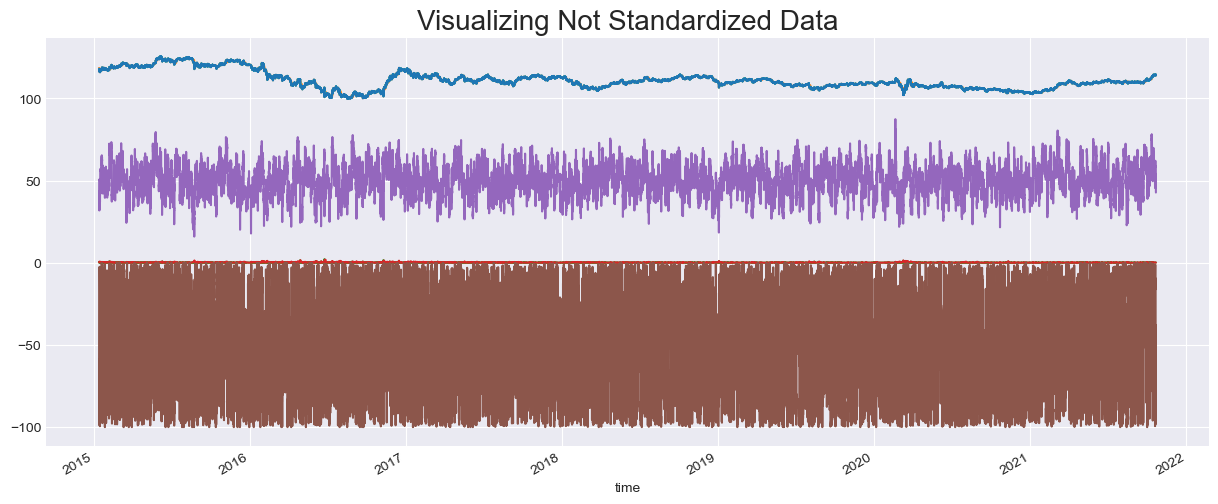

In [115]:
# Plotting features before standardization to visualize their unequal scales
X_train.plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Not Standardized Data", fontsize=20)
plt.show()

### Applying StandardScaler to Normalize Features

In [118]:
from sklearn.preprocessing import StandardScaler

In [120]:
# Only the feature sets (X) need to be standardized, not the targets (y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

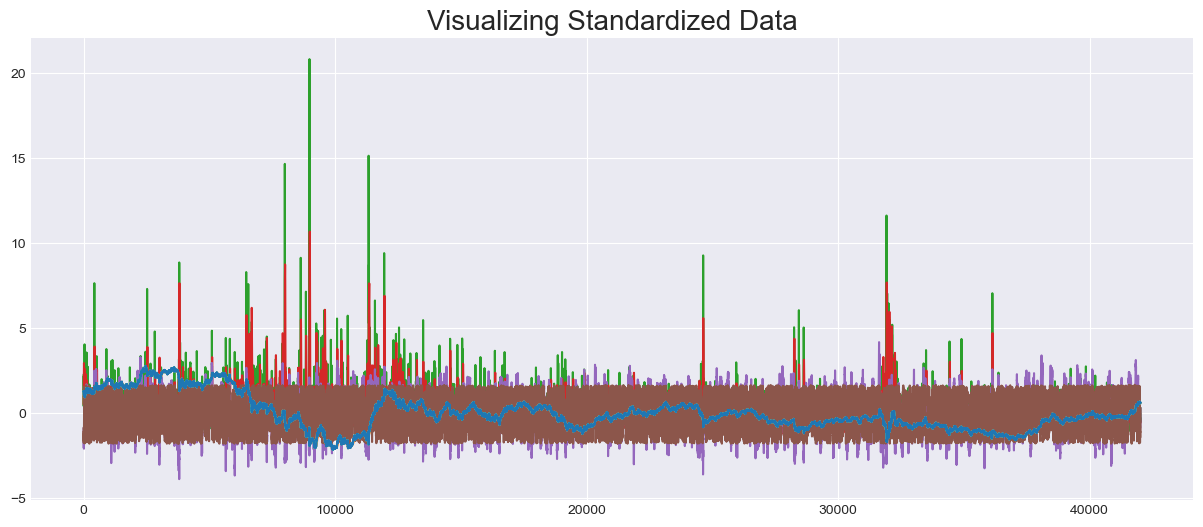

In [124]:
pd.DataFrame(X_train_scaled).plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Standardized Data", fontsize=20)
plt.show()